In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
def sample_data(bs, up=True, device='cpu'):
    if up:
        x_1 = torch.randint(low=0, high=2, size=(bs, 2), device=device)
        x_1[:,1] = torch.randint(low=1, high=2, size=(bs,), device=device)
    else:
        x_1 = torch.randint(low=0, high=2, size=(bs, 2), device=device)
        x_1[:,1] = torch.randint(low=0, high=1, size=(bs,), device=device)
    x_1 = 3 * (x_1.float() - 0.5)
    x_1 += 0.4 * torch.randn(bs,2, device=device)
    return x_1

ndim = 2
t_0, t_1 = 0.0, 1.0
beta_0 = 0.1
beta_1 = 20.0

In [3]:
def log_alpha(t):
    return -0.5*t*beta_0-0.25*t**2*(beta_1-beta_0)

def log_sigma(t):
    # original has jnp.log(t), but this is not stable for t=0, so use clamp
    return torch.log(torch.clamp(t, min=1e-6))

def dlog_alphadt(t):
    t = t.detach().requires_grad_(True)
    out = log_alpha(t)
    grad_out = grad(out.sum(), t, create_graph=True)[0]
    return grad_out

def dlog_sigmadt(t):
    t = t.detach().requires_grad_(True)
    out = log_sigma(t)
    grad_out = grad(out.sum(), t, create_graph=True)[0]
    return grad_out

def beta(t):
    return (1 + 0.5*t*beta_0 + 0.5*t**2*(beta_1-beta_0))

def q_t(data, t, device='cpu'):
    eps = torch.randn_like(data)
    x_t = torch.exp(log_alpha(t))*data + torch.exp(log_sigma(t))*eps
    return eps, x_t


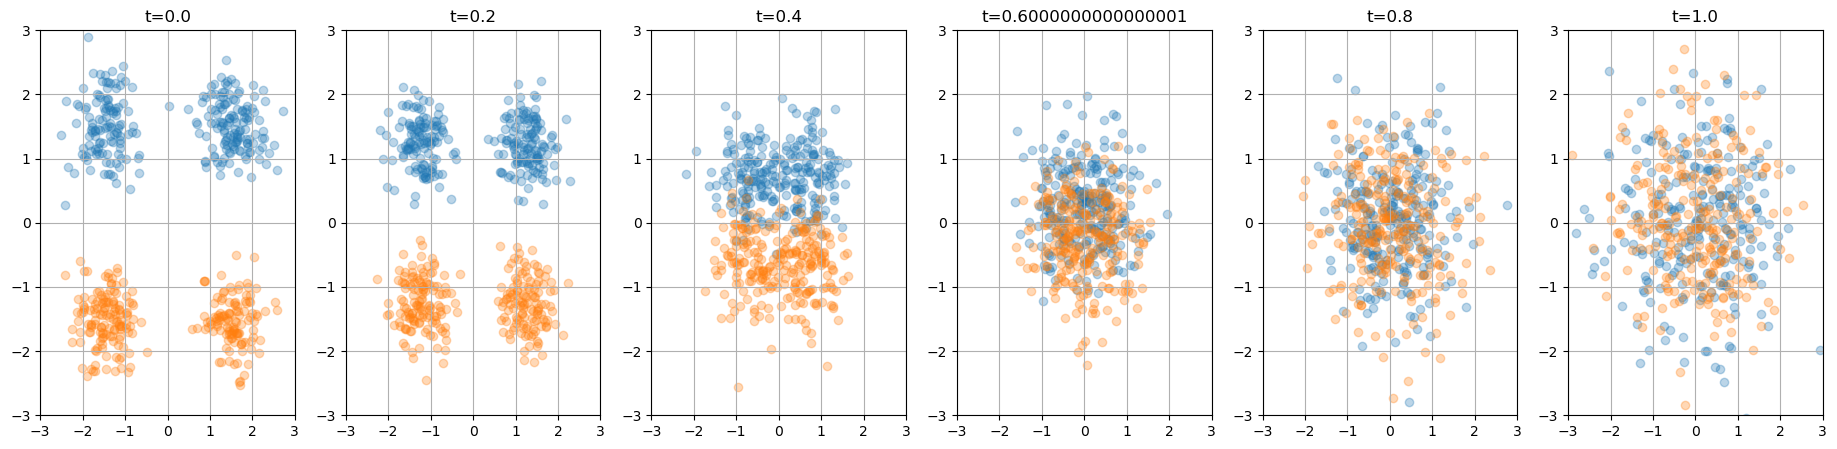

In [4]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bs = 512
t_axis = np.linspace(0.0, 1.0, 6)

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
    plt.subplot(1,len(t_axis),i+1)
    t = torch.tensor(t_axis[i], device=device).view(1,1)
    x_up = sample_data(bs//2, up=True, device=device)
    x_down = sample_data(bs//2, up=False, device=device)
    _, x_t_up = q_t(x_up, t, device=device)
    _, x_t_down = q_t(x_down, t, device=device)
    plt.scatter(x_t_up.cpu()[:,0], x_t_up.cpu()[:,1], alpha=0.3)
    plt.scatter(x_t_down.cpu()[:,0], x_t_down.cpu()[:,1], alpha=0.3)
    plt.title(f't={t_axis[i]}')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.grid()
plt.show()


In [5]:

class MLP(nn.Module):
    def __init__(self, num_hid, num_out):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(ndim+1, num_hid),
            nn.SiLU(),
            nn.Linear(num_hid, num_hid),
            nn.SiLU(),
            nn.Linear(num_hid, num_hid),
            nn.SiLU(),
            nn.Linear(num_hid, num_hid),
            nn.SiLU(),
            nn.Linear(num_hid, num_out)
        )
    def forward(self, t, x):
        # t: (batch, 1), x: (batch, ndim)
        h = torch.cat([t, x], dim=1)
        out = self.layers(h)
        return out


In [6]:
def train_model(data_generator, device='cpu'):
    model = MLP(num_hid=512, num_out=ndim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    num_iterations = 20000
    bs = 512

    for iter in trange(num_iterations):
        optimizer.zero_grad()
        data = data_generator(bs, device=device)
        t = torch.rand(bs, 1, device=device)
        eps, x_t = q_t(data, t, device=device)
        sdlogqdx = model(t, x_t)
        loss = ((eps + sdlogqdx)**2).sum(1).mean()
        loss.backward()
        optimizer.step()
    return model

In [7]:
state_up = train_model(partial(sample_data, up=True), device=device)
state_down = train_model(partial(sample_data, up=False), device=device)

/home/molef/micromamba/envs/cxr_superdiff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 20000/20000 [00:26<00:00, 742.29it/s]


In [8]:
def vector_field_SDE(model, t, x):
    sdlogqdx = model(t, x)
    dxdt = dlog_alphadt(t)*x - 2*beta(t)*sdlogqdx
    return dxdt

def generate_samples(model, device='cpu'):
    dt = 1e-2
    t_val = 1.0
    n = int(t_val/dt)
    bs = 512
    t = torch.full((bs,1), t_val, device=device)
    x_gen = torch.zeros((bs,n+1,ndim), device=device)
    x_gen[:,0,:] = torch.randn(bs, ndim, device=device)
    for i in trange(n):
        xi = x_gen[:,i,:]
        dx = -dt*vector_field_SDE(model, t, xi)
        noise = torch.sqrt(2*torch.exp(log_sigma(t))*beta(t)*dt) * torch.randn(bs, ndim, device=device)
        x_gen[:,i+1,:] = xi + dx + noise
        t -= dt
    return x_gen

In [10]:
x_gen = generate_samples(state_down, device=device)
x_gen_down = x_gen[:,-1,:].cpu()


100%|██████████| 100/100 [00:00<00:00, 289.50it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/molef/micromamba/envs/cxr_superdiff/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_331149/1400571196.py", line 8, in <module>
    plt.scatter(x_gen.detach().cpu()[:,int(x_gen.shape[1]*(t_axis[i])),0], x_gen.detach().cpu()[:,int(x_gen.shape[1]*(t_axis[i])),1], label='gen_data', color='green')
IndexError: index 101 is out of bounds for dimension 1 with size 101

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/molef/micromamba/envs/cxr_superdiff/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2170, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/molef/micromamba/envs/cxr_superdiff/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1457, in structured_traceback
    return FormattedTB.structured_

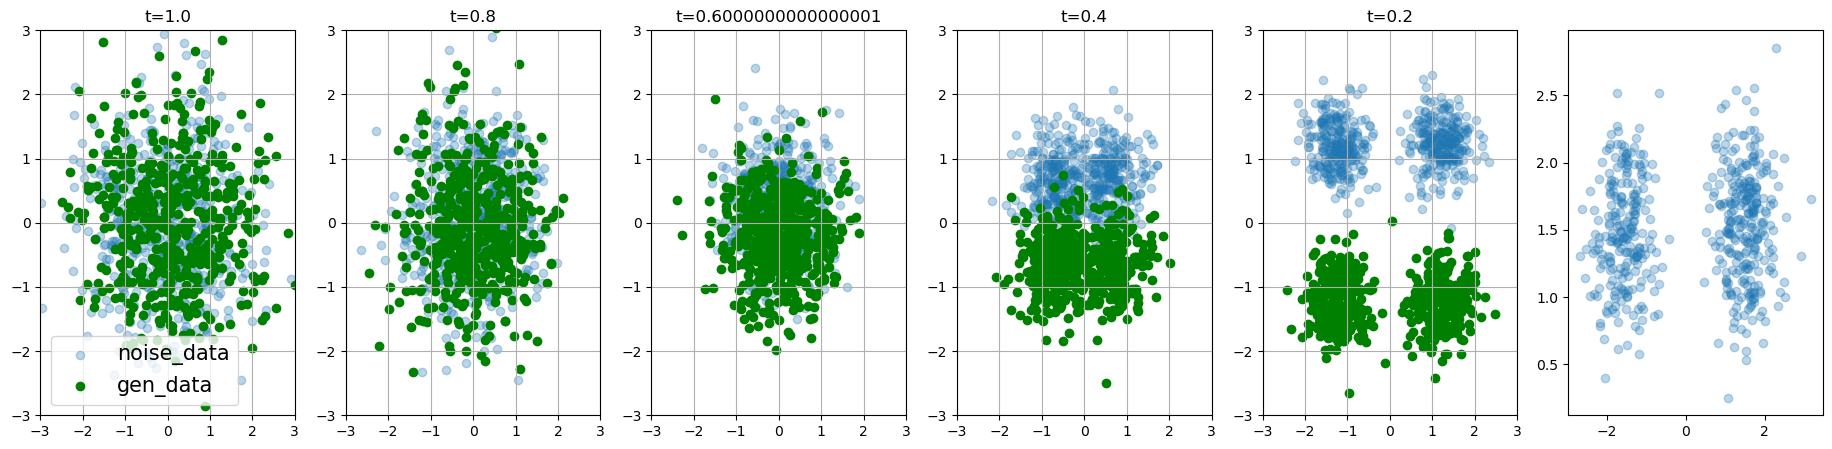

In [14]:

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
    plt.subplot(1,len(t_axis),i+1)
    t = torch.tensor(t_axis[len(t_axis)-1-i], device=device).view(1,1)
    x_data = sample_data(bs, up=True, device=device)
    _, x_t = q_t(x_data, t, device=device)
    plt.scatter(x_t.cpu()[:,0], x_t.cpu()[:,1], label='noise_data', alpha=0.3)
    plt.scatter(x_gen.detach().cpu()[:,int(x_gen.shape[1]*(t_axis[i])),0], x_gen.detach().cpu()[:,int(x_gen.shape[1]*(t_axis[i])),1], label='gen_data', color='green')
    plt.title(f't={t_axis[len(t_axis)-1-i]}')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.grid()
    if i == 0:
        plt.legend(fontsize=15)
plt.show()

100%|██████████| 100/100 [00:00<00:00, 231.79it/s]
Traceback (most recent call last):
  File "/home/molef/micromamba/envs/cxr_superdiff/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_331149/159697414.py", line 12, in <module>
    plt.scatter(x_gen.detach().cpu()[:,int(x_gen.shape[1]*(t_axis[i])),0], x_gen.detach().cpu()[:,int(x_gen.shape[1]*(t_axis[i])),1], label='gen_data', color='green')
IndexError: index 101 is out of bounds for dimension 1 with size 101

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/molef/micromamba/envs/cxr_superdiff/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2170, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/molef/micromamba/envs/cxr_superdiff/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1457, in stru

Unexpected exception formatting exception. Falling back to standard exception


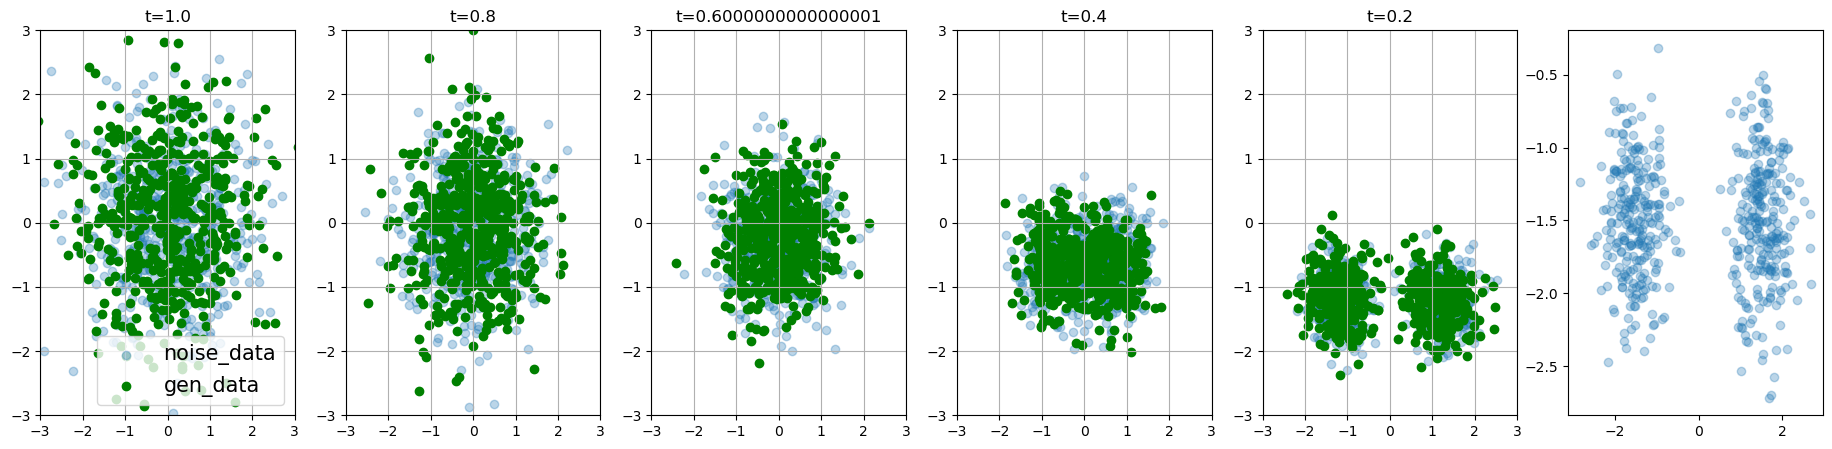

In [15]:
# Cell 9
x_gen = generate_samples(state_down, device=device)
x_gen_down = x_gen[:,-1,:].cpu()

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
    plt.subplot(1,len(t_axis),i+1)
    t = torch.tensor(t_axis[len(t_axis)-1-i], device=device).view(1,1)
    x_data = sample_data(bs, up=False, device=device)
    _, x_t = q_t(x_data, t, device=device)
    plt.scatter(x_t.cpu()[:,0], x_t.cpu()[:,1], label='noise_data', alpha=0.3)
    plt.scatter(x_gen.detach().cpu()[:,int(x_gen.shape[1]*(t_axis[i])),0], x_gen.detach().cpu()[:,int(x_gen.shape[1]*(t_axis[i])),1], label='gen_data', color='green')
    plt.title(f't={t_axis[len(t_axis)-1-i]}')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.grid()
    if i == 0:
        plt.legend(fontsize=15)
plt.show()

In [16]:
# Cell 10
def vector_field(model, t, x):
    # Compute gradient and divergence via autograd
    x.requires_grad_(True)
    sdlogdx_val = model(t, x)
    divlog_val = torch.zeros(x.size(0), 1, device=x.device)
    for i in range(x.size(1)):
        grad_outputs = torch.zeros_like(sdlogdx_val)
        grad_outputs[:,i] = 1
        component_grad = grad(sdlogdx_val[:,i].sum(), x, create_graph=True)[0][:,i]
        divlog_val += component_grad.unsqueeze(1)
    x.requires_grad_(False)
    return sdlogdx_val, divlog_val

def get_dll(t, x, sdlogdx_val, divlog_val, dxdt):
    v = dlog_alphadt(t) * x - beta(t) * sdlogdx_val
    dlldt = -dlog_alphadt(t) * ndim + beta(t) * divlog_val
    dlldt += -((sdlogdx_val/torch.exp(log_sigma(t)))*(v-dxdt)).sum(1, keepdims=True)
    return dlldt

def get_kappa(t, divlogs, sdlogdxs):
    divlog_1, divlog_2 = divlogs
    sdlogdx_1, sdlogdx_2 = sdlogdxs
    kappa = torch.exp(log_sigma(t))*(divlog_1-divlog_2) + (sdlogdx_1*(sdlogdx_1-sdlogdx_2)).sum(1, keepdims=True)
    kappa = kappa / ((sdlogdx_1-sdlogdx_2)**2).sum(1, keepdims=True)
    return kappa

In [17]:
# Cell 11
bs = 512
dt = 1e-3
t_val = 1.0
n = int(t_val/dt)
t = torch.full((bs, 1), t_val, device=device)
x_gen = torch.zeros((bs, n+1, ndim), device=device)
x_gen[:,0,:] = torch.randn(bs, ndim, device=device)
ll_1 = np.zeros((bs, n+1))
ll_2 = np.zeros((bs, n+1))

for i in trange(n):
    x_t = x_gen[:,i,:]
    t_batch = t
    sdlogdx_1, divdlog_1 = vector_field(state_up, t_batch, x_t)
    sdlogdx_2, divdlog_2 = vector_field(state_down, t_batch, x_t)
    kappa = get_kappa(t_batch, (divdlog_1, divdlog_2), (sdlogdx_1, sdlogdx_2))
    dxdt = dlog_alphadt(t_batch) * x_t - beta(t_batch) * (sdlogdx_2 + kappa * (sdlogdx_1 - sdlogdx_2))
    x_gen[:,i+1,:] = x_t - dt * dxdt
    ll_1[:,i+1] = ll_1[:,i] - dt * get_dll(t_batch, x_t, sdlogdx_1, divdlog_1, dxdt).squeeze().cpu().numpy()
    ll_2[:,i+1] = ll_2[:,i] - dt * get_dll(t_batch, x_t, sdlogdx_2, divdlog_2, dxdt).squeeze().cpu().numpy()
    t = t - dt

  0%|          | 0/1000 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/molef/micromamba/envs/cxr_superdiff/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_331149/246522258.py", line 20, in <module>
    ll_1[:,i+1] = ll_1[:,i] - dt * get_dll(t_batch, x_t, sdlogdx_1, divdlog_1, dxdt).squeeze().cpu().numpy()
RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/molef/micromamba/envs/cxr_superdiff/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2170, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/molef/micromamba/envs/cxr_superdiff/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1457, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/m